In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('heart.csv')
print(df.shape)
df.head()

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()
df.describe()
df['HeartDisease'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

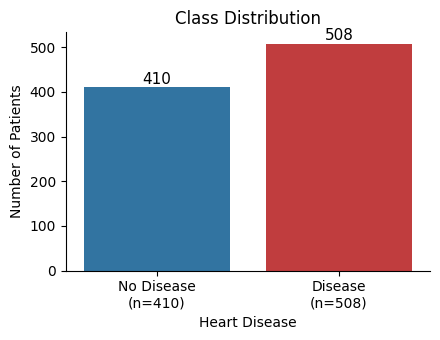

In [4]:
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)
plt.figure(figsize=(4.5, 3.5))
ax = sns.countplot(
    data=df, 
    x='HeartDisease',
    hue='HeartDisease',
    palette=['#1f77b4', '#d62728'],
    legend=False
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 8,
            f'{int(height)}', ha="center", fontsize=11)

plt.xlabel('Heart Disease')
plt.ylabel('Number of Patients')
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1], labels=['No Disease\n(n=410)', 'Disease\n(n=508)'])
sns.despine()
plt.tight_layout()
plt.savefig('class_distribution.pdf')
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']

In [6]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

In [37]:
model1 = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

auc_scores = cross_val_score(model1, X, y, cv=10, scoring='roc_auc')
acc_scores = cross_val_score(model1, X, y, cv=10, scoring='accuracy')
recall_scores = cross_val_score(model1, X, y, cv=10, scoring='recall')
f1_scores = cross_val_score(model1, X, y, cv=10, scoring='f1')

print("Logistic Regression AUC-ROC (10-fold):", auc_scores.mean().round(4), "±", auc_scores.std().round(4))
print("Accuracy:", acc_scores.mean().round(4))
print("Recall (doença):", recall_scores.mean().round(4))
print("F1-score:", f1_scores.mean().round(4))

Logistic Regression AUC-ROC (10-fold): 0.9196 ± 0.0446
Accuracy: 0.8506
Recall (doença): 0.8695
F1-score: 0.8639


In [38]:
model2 = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42,
        class_weight='balanced'
    ))
])

auc_scores = cross_val_score(model2, X, y, cv=10, scoring='roc_auc')
acc_scores = cross_val_score(model2, X, y, cv=10, scoring='accuracy')
recall_scores = cross_val_score(model2, X, y, cv=10, scoring='recall')
f1_scores = cross_val_score(model2, X, y, cv=10, scoring='f1')

print("Random Forest AUC-ROC (10-fold):", auc_scores.mean().round(4), "±", auc_scores.std().round(4))
print("Accuracy:", acc_scores.mean().round(4))
print("Recall (doença):", recall_scores.mean().round(4))
print("F1-score:", f1_scores.mean().round(4))

Random Forest AUC-ROC (10-fold): 0.9198 ± 0.0503
Accuracy: 0.8484
Recall (doença): 0.8695
F1-score: 0.8613


In [ ]:
model3 = Pipeline([
    ('prep', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ))
])

auc_scores = cross_val_score(model3, X, y, cv=10, scoring='roc_auc')
acc_scores = cross_val_score(model3, X, y, cv=10, scoring='accuracy')
recall_scores = cross_val_score(model3, X, y, cv=10, scoring='recall')
f1_scores = cross_val_score(model3, X, y, cv=10, scoring='f1')

print("XGBoost AUC-ROC (10-fold):", auc_scores.mean().round(4), "±", auc_scores.std().round(4))
print("Accuracy:", acc_scores.mean().round(4))
print("Recall (doença):", recall_scores.mean().round(4))
print("F1-score:", f1_scores.mean().round(4))

XGBoost AUC-ROC (10-fold): 0.9184 ± 0.0496
Accuracy: 0.8539
Recall (doença): 0.8776
F1-score: 0.8676


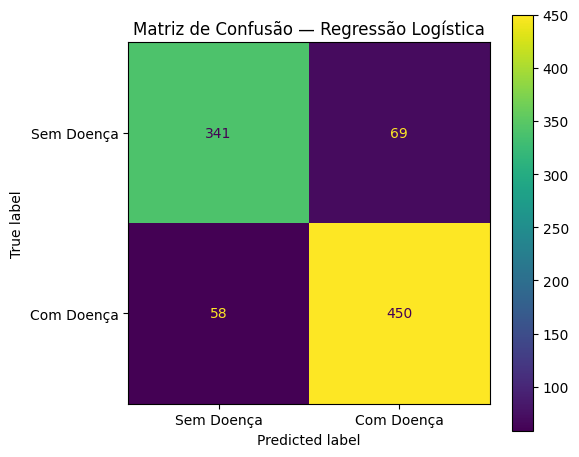

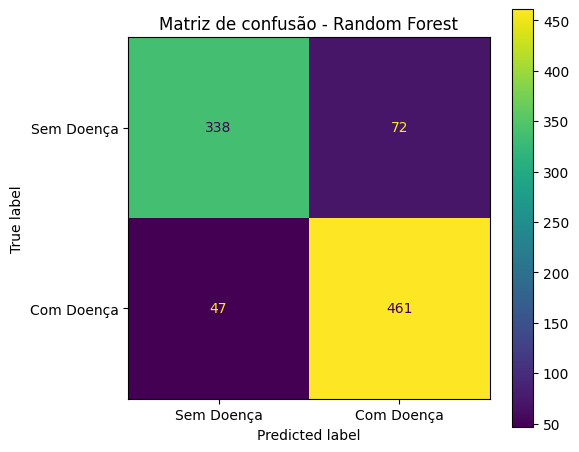

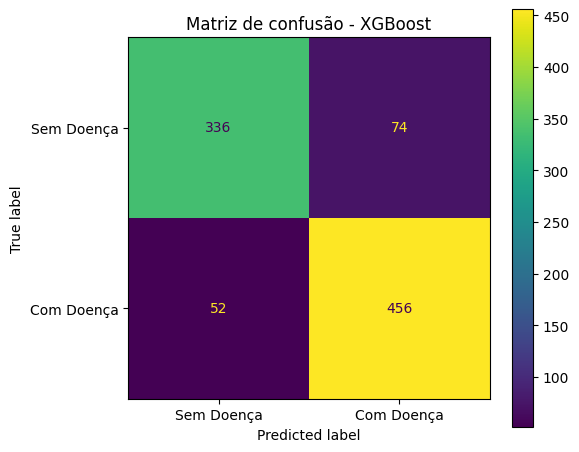

In [40]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

conf_matrix_total = np.zeros((2, 2))

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model1_fit = model1.fit(X_train, y_train)
    y_pred_fold = model1.predict(X_test)
    
    conf_matrix_total += confusion_matrix(y_test, y_pred_fold)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_total.astype(int),
                                  display_labels=['Sem Doença', 'Com Doença'])
disp.plot(cmap='viridis', ax=plt.gca(), values_format='d')
plt.title('Matriz de Confusão — Regressão Logística')
plt.tight_layout()
plt.savefig('cm_logistic.pdf', bbox_inches='tight')
plt.show()
plt.close()

conf_matrix_total = np.zeros((2, 2))

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model2.fit(X_train, y_train)
    y_pred_fold = model2.predict(X_test)
    
    conf_matrix_total += confusion_matrix(y_test, y_pred_fold)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_total.astype(int),
                                  display_labels=['Sem Doença', 'Com Doença'])
disp.plot(cmap='viridis', ax=plt.gca(), values_format='d')
plt.title('Matriz de confusão - Random Forest')
plt.tight_layout()
plt.savefig('cm_randomforest.pdf', bbox_inches='tight')
plt.show()
plt.close()

conf_matrix_total = np.zeros((2, 2))

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model3.fit(X_train, y_train)
    y_pred_fold = model3.predict(X_test)
    
    conf_matrix_total += confusion_matrix(y_test, y_pred_fold)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_total.astype(int),
                                  display_labels=['Sem Doença', 'Com Doença'])
disp.plot(cmap='viridis', ax=plt.gca(), values_format='d')
plt.title('Matriz de confusão - XGBoost')
plt.tight_layout()
plt.savefig('cm_xgboost.pdf', bbox_inches='tight')
plt.show()
plt.close()

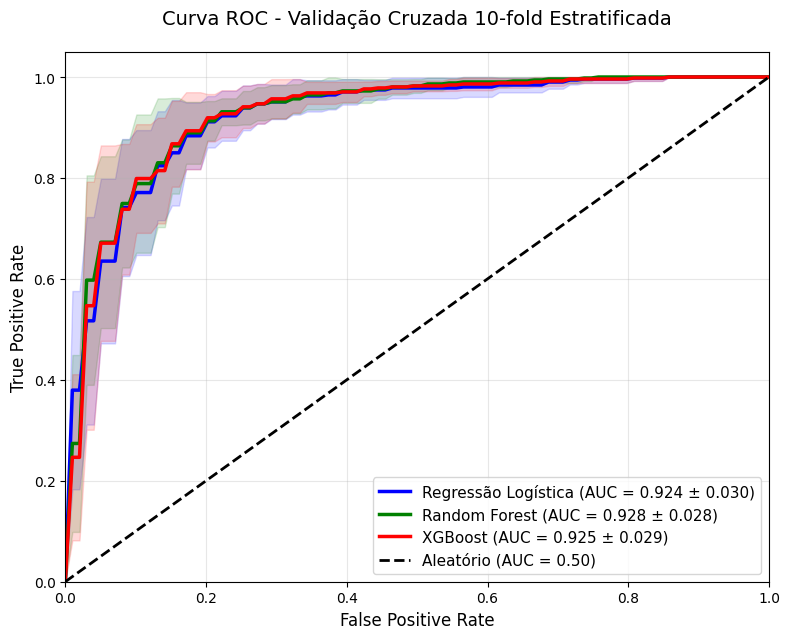

In [ ]:
def plot_roc_cv_correct(models, names, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    plt.figure(figsize=(8, 6.5))
    
    colors = ['blue', 'green', 'red']
    for i, (model, name) in enumerate(zip(models, names)):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        
        plt.plot(mean_fpr, mean_tpr, color=colors[i], lw=2.5,
                 label=f'{name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
        
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=0.15)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aleatório (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Curva ROC - Validação Cruzada 10-fold Estratificada', fontsize=14, pad=20)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve_cv_correct.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('roc_curve_cv_correct.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_roc_cv_correct(
    models=[model1, model2, model3],
    names=['Regressão Logística', 'Random Forest', 'XGBoost'],
    X=X, y=y
)

In [46]:
def get_feature_importance_cv(model, X, y, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    prep = model.named_steps['prep']
    feature_names = (num_cols + 
                     list(prep.named_transformers_['cat'].get_feature_names_out(cat_cols)))
    
    importance_list = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        model.fit(X_train, y_train)
        importances = model.named_steps['clf'].feature_importances_
        importance_list.append(importances)
    
    mean_importance = np.mean(importance_list, axis=0)
    std_importance = np.std(importance_list, axis=0)
    
    imp_series = pd.Series(mean_importance, index=feature_names)
    std_series = pd.Series(std_importance, index=feature_names)
    
    return imp_series.sort_values(ascending=False), std_series

rf_imp, rf_std = get_feature_importance_cv(model2, X, y)
xgb_imp, xgb_std = get_feature_importance_cv(model3, X, y)

print("=== Random Forest (média 10-fold) ===")
print(rf_imp.head(10).round(4))

print("\n=== XGBoost (média 10-fold) ===")
print(xgb_imp.head(10).round(4))

=== Random Forest (média 10-fold) ===
ST_Slope_Up          0.1765
ST_Slope_Flat        0.1290
Oldpeak              0.1140
MaxHR                0.1003
Cholesterol          0.0954
ExerciseAngina_Y     0.0952
Age                  0.0664
RestingBP            0.0569
ChestPainType_ATA    0.0421
Sex_M                0.0419
dtype: float64

=== XGBoost (média 10-fold) ===
ST_Slope_Up          0.4763
ST_Slope_Flat        0.0956
ExerciseAngina_Y     0.0600
Sex_M                0.0566
FastingBS            0.0432
ChestPainType_ATA    0.0423
ChestPainType_NAP    0.0364
Oldpeak              0.0297
ChestPainType_TA     0.0296
Cholesterol          0.0274
dtype: float32


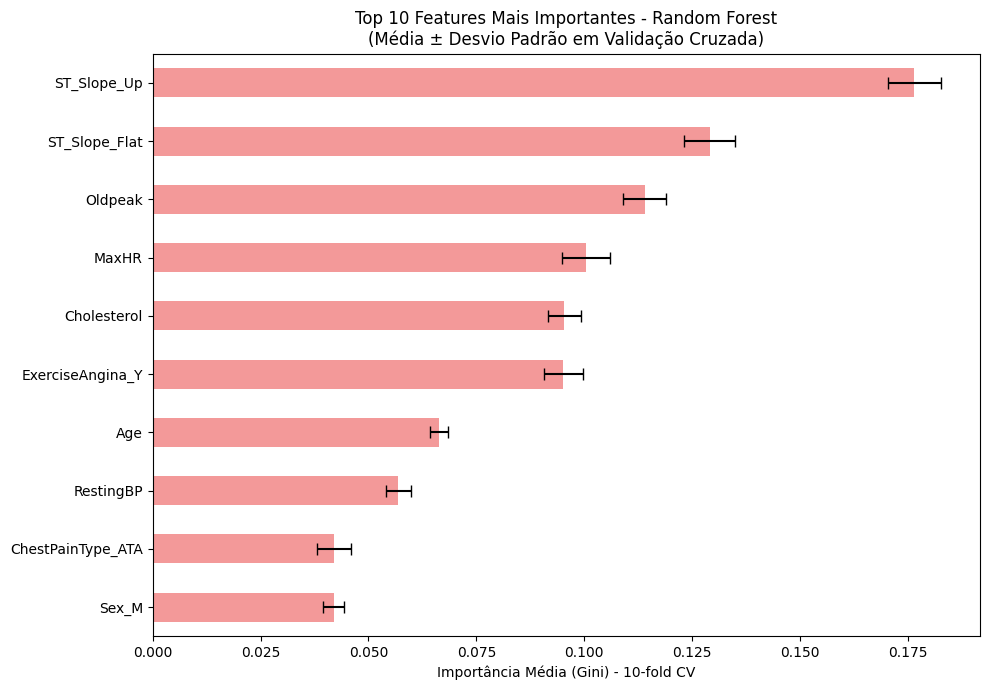

In [47]:
plt.figure(figsize=(10, 7))
top10 = rf_imp.head(10)
errors = rf_std[top10.index]

top10.plot(kind='barh', xerr=errors, capsize=4, color='lightcoral', alpha=0.8)
plt.xlabel('Importância Média (Gini) - 10-fold CV')
plt.title('Top 10 Features Mais Importantes - Random Forest\n(Média ± Desvio Padrão em Validação Cruzada)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_rf_cv.pdf', dpi=300, bbox_inches='tight')
plt.show()

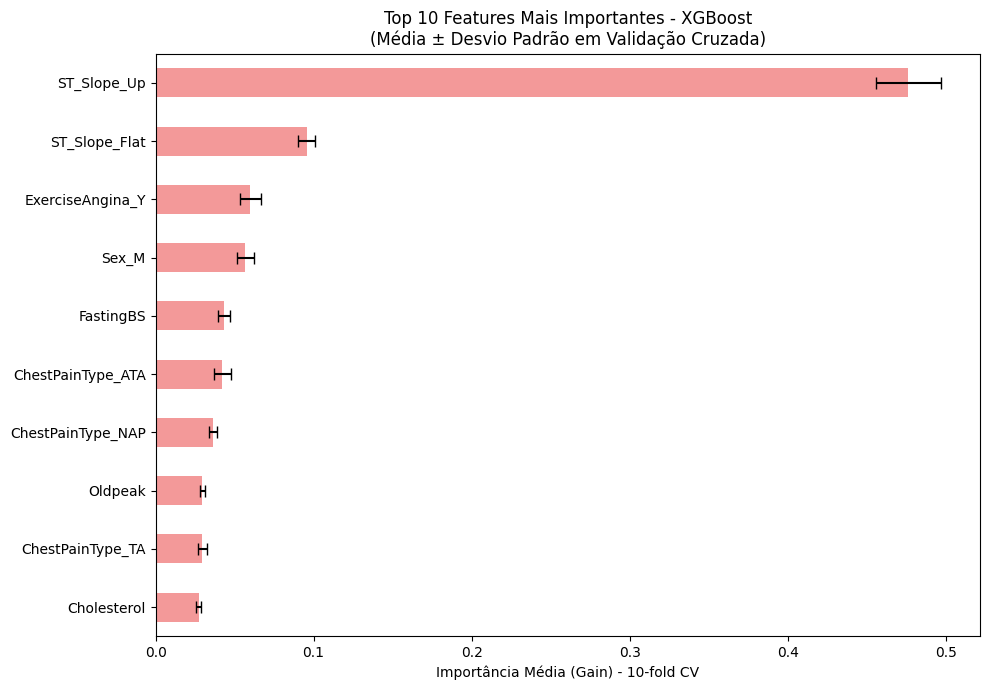

In [48]:
plt.figure(figsize=(10, 7))
top10 = xgb_imp.head(10)
errors = xgb_std[top10.index]

top10.plot(kind='barh', xerr=errors, capsize=4, color='lightcoral', alpha=0.8)
plt.xlabel('Importância Média (Gain) - 10-fold CV')
plt.title('Top 10 Features Mais Importantes - XGBoost\n(Média ± Desvio Padrão em Validação Cruzada)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_xgb_cv.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_6251/170503236.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='HeartDisease', y='Oldpeak', palette='Set2')


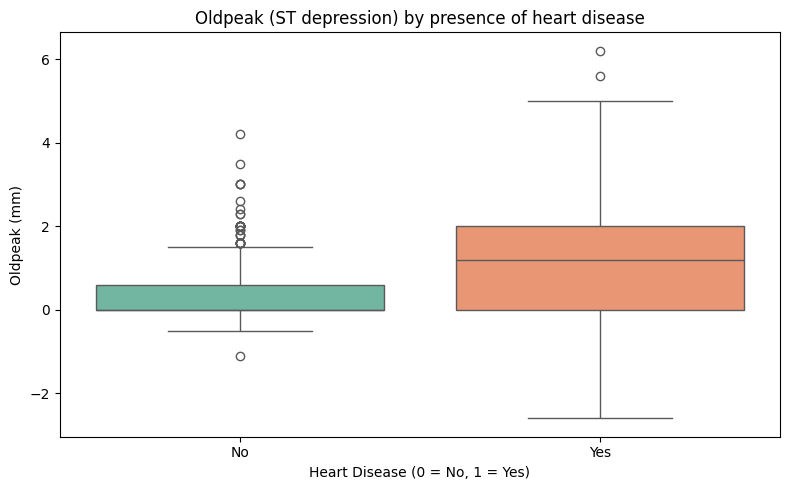

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='HeartDisease', y='Oldpeak', palette='Set2')
plt.title('Oldpeak (ST depression) by presence of heart disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Oldpeak (mm)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.savefig('oldpeak_by_heartdisease.pdf', bbox_inches='tight')
plt.show()

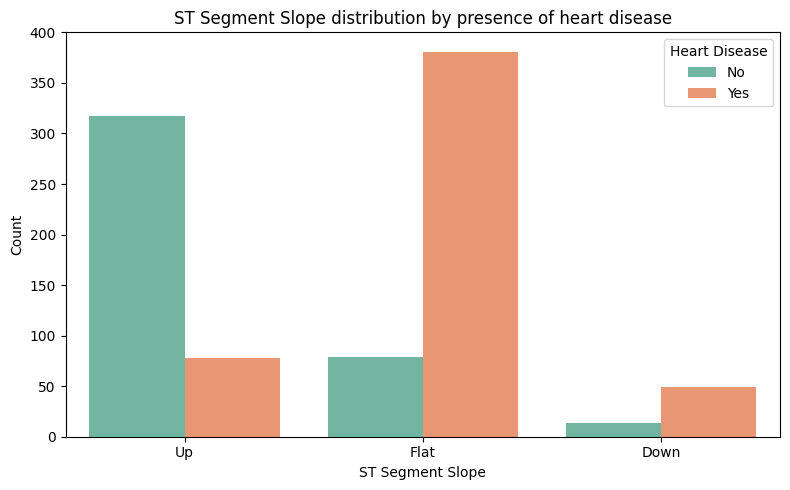

In [19]:
plt.figure(figsize=(8, 5))
order = ['Up', 'Flat', 'Down']
sns.countplot(data=df, x='ST_Slope', hue='HeartDisease', order=order, palette='Set2')
plt.title('ST Segment Slope distribution by presence of heart disease')
plt.xlabel('ST Segment Slope')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.tight_layout()
plt.savefig('stslope_by_heartdisease.pdf', bbox_inches='tight')
plt.show()